In [43]:
from langchain_ollama import ChatOllama

def get_llm_reasoner_model():
    return ChatOllama(
        model="deepseek-r1:14b",
        temperature=0.6
    )

def extract_result_from_tags(tag: str, result: str):
    if "</think>" in result:
        result = result.split("</think>")[1]

    if f"<{tag}>" in result:
        return result.split(f"<{tag}>")[1].split(f"</{tag}>")[0]

    return result


def extract_result_from_tags(tag: str, result: str):
    if "</think>" in result:
        result = result.split("</think>")[1]

    if f"<{tag}>" in result:
        return result.split(f"<{tag}>")[1].split(f"</{tag}>")[0]

    return result

In [44]:
import operator
from typing import TypedDict
from typing_extensions import Annotated


class InputState(TypedDict):
    topic: str
    max_web_searchs: int


class OutputState(TypedDict):
    summary: str


class OverallState(InputState, OutputState):
    search_query: str
    research_loop_count: int
    sources_gathered: Annotated[list, operator.add]
    web_search_results: Annotated[list, operator.add]

In [57]:
from tavily import TavilyClient


def tavily_search(query: str):
    print("Searching Tavily for:", query)
    tavily = TavilyClient()
    return tavily.search(query, max_results=2)


def get_response_str(search_response: dict):
    sources_list = search_response['results']

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"

    return formatted_text.strip()


def get_sources_from_search_results(search_response: list):
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_response['results']
    )

In [66]:
from typing_extensions import Literal


def generate_first_query(state: InputState):
    """
    Generate a search query based on the topic provided in the state.
    """

    prompt = (
        f"Your goal is to generate a targeted web search query."
        "The query will gather information related to a specific topic."
        "Do not give me extra information, all I need is a search query"
        f"The topic is: {state['topic']}"
        "Please return the query wrapped in <query> tags. For example: <query>Suggested query</query>"
    )

    reasoner_llm = get_llm_reasoner_model()
    response = reasoner_llm(prompt)
    query = extract_result_from_tags("query", response.content)

    return {"search_query": query}


def web_search_generator(state: OverallState):
    """
    Gather web search results based on the search query.
    """

    search_results = tavily_search(state['search_query'])

    return {
        "sources_gathered": [get_sources_from_search_results(search_results)],
        "web_search_results": [search_results],
        "research_loop_count": state["research_loop_count"] + 1 if "research_loop_count" in state else 1
    }


def summarize_sources(state: OverallState):
    """
    Generate a summary based on the sources gathered.
    """

    existing_summary = state.get("summary", "")

    last_web_search = state["web_search_results"][-1]

    prompt = (
        "Generate a high-quality summary of the web search results and keep it related to the topic."
        "Highlight the most relevant information related to the topic from the search results"
        "The topic is: {state['topic']}"
    )

    if existing_summary != "":
        prompt += (
            "Compare the new information with the existing summary. "
            "For each piece of new information:"
            "If it's related to existing points, integrate it into the relevant paragraph."
            "If it's entirely new but relevant, add a new paragraph with a smooth transition."
            "If it's not relevant to the user topic, skip it."
            f"\nPlease extend the existing summary with the new information from the latest search results."
            f"\nExisting summary: {existing_summary}"
            f"\nNew search results: {last_web_search}"
        )
    else:
        prompt += f"\nSearch results: {last_web_search}"

    prompt += "Please return the summary wrapped in <summary> tags. For example: <summary>Suggested summary</summary>"

    reasoner_llm = get_llm_reasoner_model()
    response = reasoner_llm(prompt)
    summary = extract_result_from_tags("summary", response.content)

    return {"summary": summary}


def reflect_on_suumary(state: OverallState):
    """
    Refelect on summary and generate a follow up query.
    """

    prompt = (
        "Identify knowledge gaps or areas that need deeper exploration"
        "Reflect on the summary and generate a follow-up question to deepen your understanding."
        "Focus on technical details, implementation specifics, or emerging trends that weren't fully covered"
        "The follow-up question should be concise enough to be a web search query"
        "The query should be at max 15 words"
        f"The topic is: {state['topic']}"
        f"The summary is: {state['summary']}"
        "Please return the query wrapped in <query> tags. For example: <query>Suggested query</query>"
    )

    reasoner_llm = get_llm_reasoner_model()
    response = reasoner_llm(prompt)
    query = extract_result_from_tags("query", response.content)

    query = query if len(query) <= 140 else f"Tell me more about {state['research_topic']}"
    return {"search_query": query}


def finalize_summary(state: OverallState):
    """ Finalize the summary """

    # Format all accumulated sources into a single bulleted list
    # Deduplicate sources
    unique_sources = list(set(state["sources_gathered"]))
    all_sources = "\n".join(source for source in unique_sources)

    final_summary = f"## Summary\n\n{state['summary']}\n\n ### Sources:\n{all_sources}"
    return {"summary": final_summary}


def reasearch_router(state: OverallState) -> Literal["finalize_summary", "web_research"]:
    """ 
    Route the research based on the follow-up query 
    """

    if state["research_loop_count"] < state["max_web_searchs"]:
        return "web_research"
    else:
        return "finalize_summary"

In [67]:
from langgraph.graph import START, END, StateGraph


def get_workflow():
    builder = StateGraph(OverallState, input=InputState, output=OutputState)

    # Add nodes
    builder.add_node("generate_first_query", generate_first_query)
    builder.add_node("web_research", web_search_generator)
    builder.add_node("summarize_sources", summarize_sources)
    builder.add_node("reflect_on_summary", reflect_on_suumary)
    builder.add_node("finalize_summary", finalize_summary)

    # Add edges
    builder.add_edge(START, "generate_first_query")
    builder.add_edge("generate_first_query", "web_research")
    builder.add_edge("web_research", "summarize_sources")
    builder.add_edge("summarize_sources", "reflect_on_summary")
    builder.add_conditional_edges("reflect_on_summary", reasearch_router)
    builder.add_edge("finalize_summary", END)

    return builder.compile()

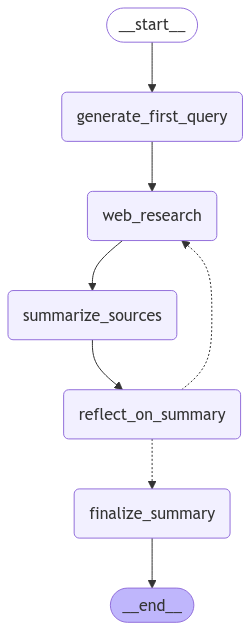

In [68]:
from IPython.display import Image, display
workflow = get_workflow()

# View
display(Image(workflow.get_graph().draw_mermaid_png()))

In [69]:
result = workflow.invoke({
    "topic": "How was deepseek r1 trained",
    "max_web_searchs": 3
})

result

Searching Tavily for: How was DeepSeek R1 trained?
Searching Tavily for: How does GRPO contribute to the training process of DeepSeek R1?
Searching Tavily for: How is GRPO integrated into DeepSeek R1's training?


{'summary': "## Summary\n\n  \nDeepSeek R1, an open-source AI model developed by DeepSeek, leverages Group Relative Policy Optimization (GRPO) as a key component in its training process. GRPO is a reinforcement learning framework that enhances the model's reasoning abilities, setting it apart from conventional large language models (LLMs). Unlike traditional methods like PPO, which rely on a separate value model, GRPO eliminates this dependency by using group-based relative advantage estimation. This approach not only reduces memory and computation costs but also streamlines the training process, making it more efficient.  \n\nGRPO simplifies the reinforcement learning process by removing the need for a separate value model, instead using group-based relative rewards for baseline estimation. This innovation makes the training process more efficient and scalable, enabling DeepSeek R1 to learn reasoning skills more effectively. The model's training follows a multi-stage approach, where G

In [65]:
from IPython.display import Markdown

Markdown(result["summary"])

## Summary

  
DeepSeek R1's training process is distinguished by its innovative combination of advanced architecture and optimization techniques. The model leverages a Mixture of Experts (MoE) architecture, which enhances efficiency by routing different sub-networks (experts) to handle specific tasks. This architecture is implemented through a multi-step training approach that integrates reinforcement learning (RL) with supervised fine-tuning (SFT).  

The DeepSeek-R1 Architecture and Training Process demonstrates how cutting-edge AI models can achieve high reasoning capabilities with cost efficiency. This article takes a deep dive into DeepSeek-R1’s Mixture of Experts (MoE) architecture, explaining its expert routing, parallelization strategy, and model specialization. The MoE architecture in DeepSeek R1 works by routing input features to the most relevant experts based on their proficiency in handling specific tasks. This routing mechanism is optimized for parallelization, allowing the model to process multiple tasks simultaneously while maintaining efficiency. Additionally, the architecture emphasizes model specialization, where each expert is trained to excel in particular domains or functions, further enhancing the model's overall performance.  

The training process begins with a pre-trained base model, DeepSeek-V3-Base, which is then fine-tuned using a Cold Start dataset to improve its reasoning capabilities. A key feature of this training is the use of reinforcement learning, where the model is optimized using reward mechanisms to favor high-quality outputs. Additionally, rejection sampling is employed to select the best responses from a large pool of generated outputs, ensuring high accuracy and consistency.  

The multi-stage training approach further refines the model by combining RL-trained outputs with data from other domains, such as writing and factual question answering, to create a more generalized and robust fine-tuning dataset. This integration of MoE architecture, RL, and multi-stage training contributes to DeepSeek R1's superior reasoning and efficiency, making it a cutting-edge model in the field of AI.  

DeepSeek-R1’s training methodology departs from traditional supervised learning and instead focuses on reinforcement learning (RL) for reasoning. DeepSeek-R1 utilizes reward modeling and reinforcement learning to fine-tune its reasoning abilities. Step 4: Train the model using reinforcement learning to favor high-reward outputs.  


 ### Sources:
* How DeepSeek-R1 Was Built: Architecture and Training Explained : https://blog.adyog.com/2025/02/01/how-deepseek-r1-was-built-architecture-and-training-explained/
* DeepSeek R1: Understanding GRPO and Multi-Stage Training : https://medium.com/@bavalpreetsinghh/deepseek-r1-understanding-grpo-and-multi-stage-training-5e0bbc28a281
* DeepSeek R1: It's All About Architecture and Training Approach : https://teqnoverse.medium.com/deepseek-r1-its-all-about-architecture-and-training-approach-50af74c223b8
* How DeepSeek-R1 Was Built: Architecture and Training Explained : https://blog.adyog.com/2025/02/01/how-deepseek-r1-was-built-architecture-and-training-explained/
* How DeepSeek-R1 Was Built: Architecture and Training Explained : https://blog.adyog.com/2025/02/01/how-deepseek-r1-was-built-architecture-and-training-explained/
* Exploring DeepSeek-R1's Mixture-of-Experts Model Architecture : https://www.modular.com/ai-resources/exploring-deepseek-r1-s-mixture-of-experts-model-architecture